In [1139]:
import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
import scipy as sc 

from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools
import warnings, pylab
warnings.filterwarnings('ignore')

from lection_utils import qualityMAPE, get_autoregrmatrix

%matplotlib inline

## Ex. 0 

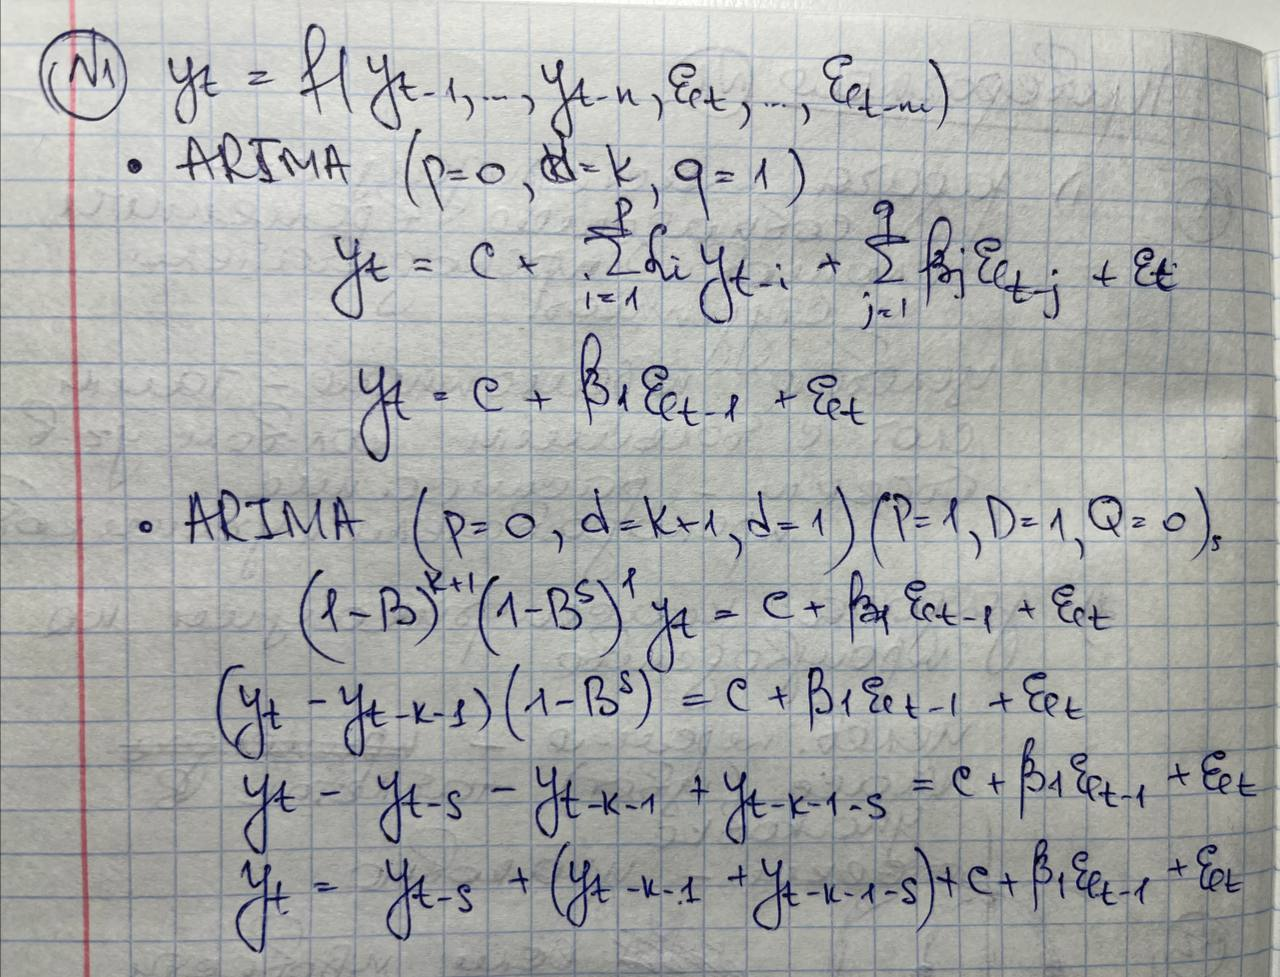

In [1140]:
from IPython.display import Image
Image('arima.jpg')

## EX 1

### Ex. 1.0 

In [1141]:
df = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/energy_consumption.csv', parse_dates=['Date'])
ts = df[df.id == 5].drop(columns='id').set_index('Date')['2011-01-01':'2014-01-01']
ts = ts.sort_index()

In [1142]:
ts.shape

(1097, 18)

In [1143]:
ts.head(3)

,EnergyConsumption,Temp1,Temp2,Temp3,Temp4,Temp5,Temp6,Temp7,Saturday,Sunday,Temp1_South_Less,Temp2_South_Less,Temp3_South_Less,Temp4_South_Less,Temp1_South_Gr,Temp2_South_Gr,Temp3_South_Gr,Temp4_South_Gr
Date,,,,,,,,,,,,,,,,,,
2011-01-01,135936.126,-6.0,-4.7,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-02,136629.379,-7.6,-5.7,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-03,140293.989,-6.3,-5.9,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1144]:
#null columns
null_col = list(ts.columns[list(ts.isna().sum()==ts.shape[0])].values)
ts = ts.drop(columns=null_col)
ts.shape

(1097, 5)

In [1145]:
ts.head(3)

,EnergyConsumption,Temp1,Temp2,Saturday,Sunday
Date,,,,,
2011-01-01,135936.126,-6.0,-4.7,1.0,0.0
2011-01-02,136629.379,-7.6,-5.7,0.0,1.0
2011-01-03,140293.989,-6.3,-5.9,0.0,1.0


### EX 1.1 plot target ts 

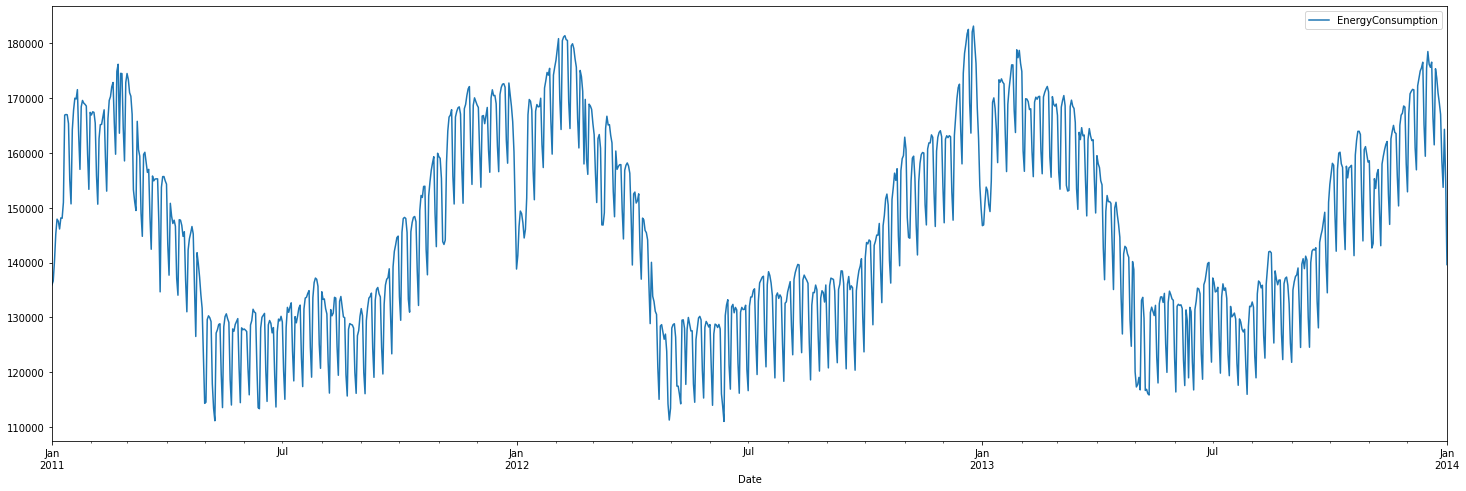

In [1146]:
target = pd.DataFrame(ts['EnergyConsumption'])
target.plot(figsize=(25,8));

<AxesSubplot:xlabel='Date'>

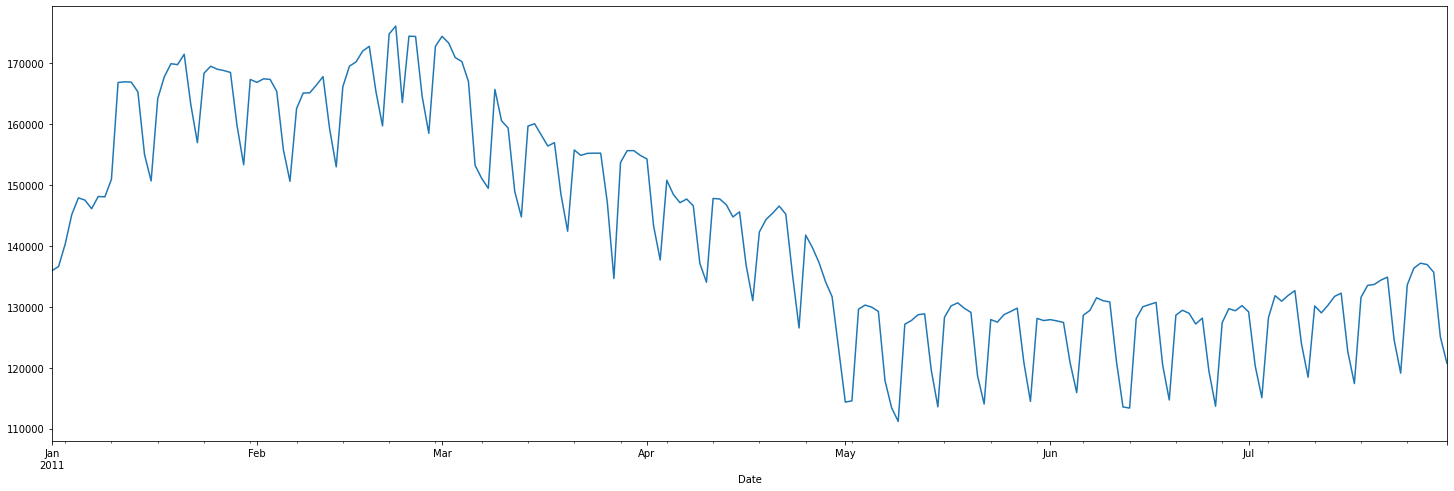

In [1147]:
# Plot 6 months in order to see week seasonality
ts['EnergyConsumption']['2011-01':'2011-07'].plot(figsize=(25,8))

### EX 1.2 plot cros-series plot: independent variables and target variable on the same subplot

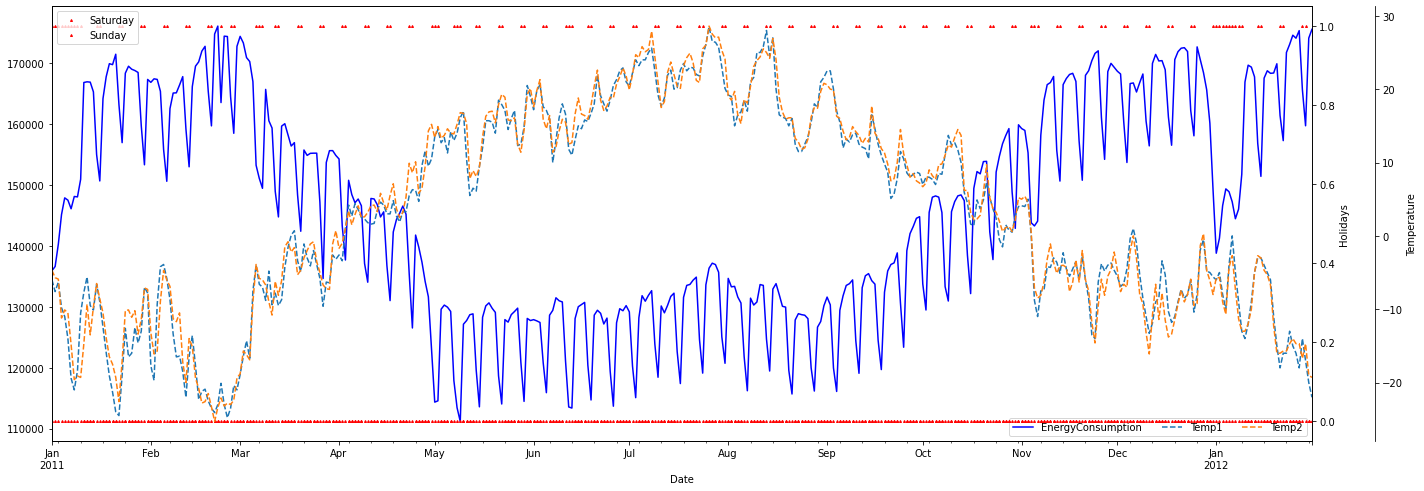

In [1149]:
fig, ax = plt.subplots(figsize=[28,8])
ax2, ax3 = ax.twinx(), ax.twinx()
ax2.set_ylabel('Holidays')
ax3.set_ylabel('Temperature')
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.05))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
fig.subplots_adjust(right=0.75)

ts_to_plot = ts.loc['2011-01':'2012-01']
ts_to_plot['EnergyConsumption'].plot(ax=ax, style='b-')
ts_to_plot[['Saturday', 'Sunday']].plot(ax=ax2, style='r-', marker='^', markersize = 2.0, linewidth=0.0)

for col in ts.columns:
    if col.startswith('Temp'):
        style='--'
        ts_to_plot[col].plot(ax=ax3, style=style)
        
lines=ax.get_lines() + ax3.get_lines()
ax.legend(lines, [l.get_label() for l in lines], loc='lower right', ncol=3)
ax2.legend(loc='upper left')
plt.show()

### Ex. 1.3 answer the questions
is there seasonality? If there is seasonality then define period(s) of seasonality.
trend?
not-stable dispersion?

1) Сезонность данных присутствует - в январе каждого года потребление выше, чем в летние месяцы, сезонность - 12 месяцев. Также наличие сезонности связано с графиком температуры. Чем выше температура - тем ниже потребление энергии в целом. Также есть отчетливый недельный тренд потребления.
2) Также виден тренд на увеличение потребления энергии - январь 11 года, ниже января 12. Минимальные значения год от года увеличиваются.
3) Дисперсия ряда кажется постоянной - нет какого-то явного изменения, определимого на глаз.

Получается, чтобы привести ряд к стационарному, необходимо избавиться от сезонности данных - недельной и годовой (с периодом s =[7, 365]). Необходимо избавиться от тренда - дифференцированием shift = 1. Преобразование Box-Cox не нужно.

## Ex. 2 Fit ARIMA Model (50%)

### Ex 2.0 split the ts to two parts: first 80% of timestamps (ts1) and the last 20% of timestamps (ts2)

In [1150]:
split_idx = round(ts['EnergyConsumption'].shape[0]/100*80)
ts.shape

(1097, 5)

In [1151]:
ts1 = pd.DataFrame(ts.iloc[:split_idx])
ts1.shape

(878, 5)

In [1152]:
ts2 = pd.DataFrame(ts.iloc[split_idx:])
ts2.shape

(219, 5)

### Ex 2.1 apply transformation to make ts1 stationary

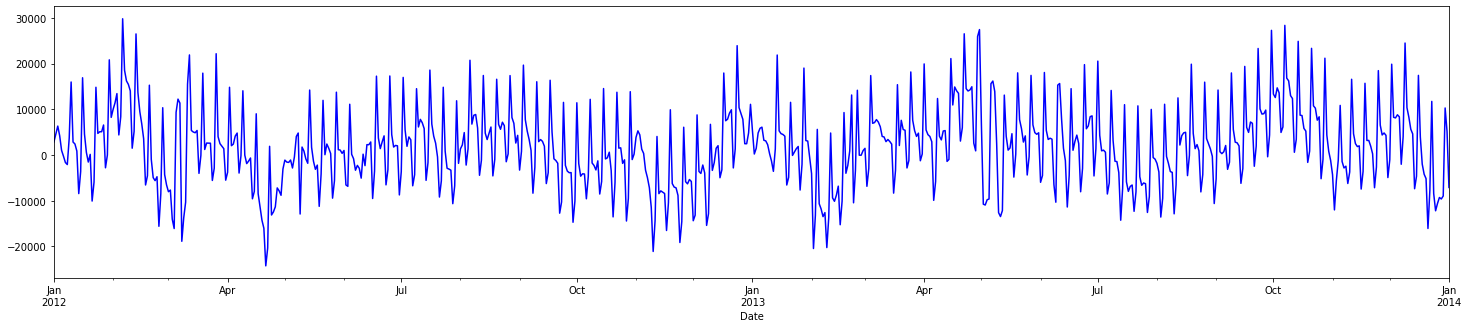

In [1153]:
# В 2012 году было 365 дней;
s1 = 365
sdiff_ts =(ts - ts.shift(s1)).iloc[s1:]
sdiff_ts['EnergyConsumption'].plot(figsize=(25, 5), color='b');

(725, 5)

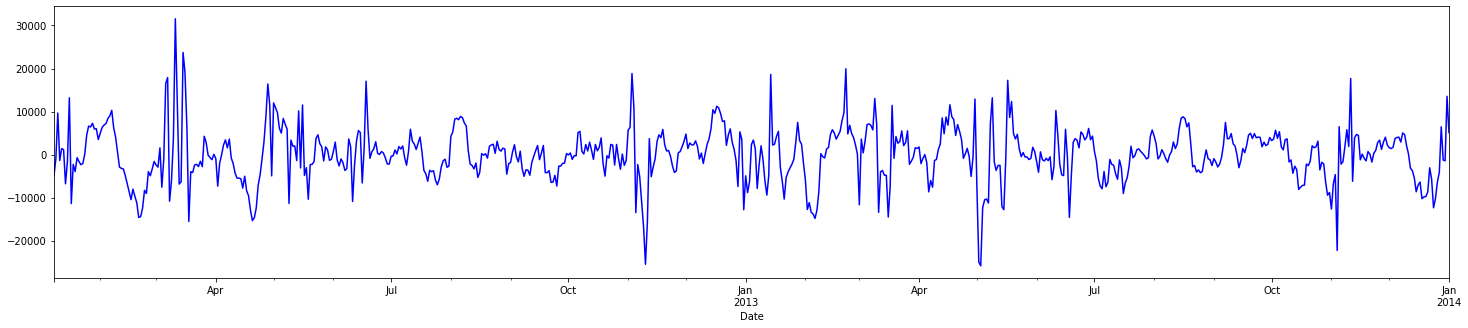

In [1154]:
s2 = 7
ssdiff_ts = (sdiff_ts - sdiff_ts.shift(s2)).iloc[s2:]
ssdiff_ts['EnergyConsumption'].plot(figsize=(25, 5), color='b');
ssdiff_ts.shape

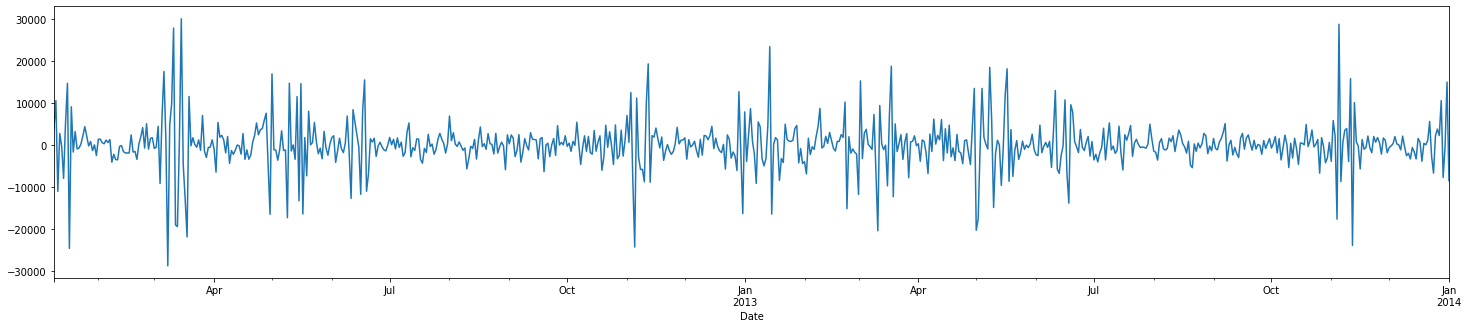

In [1155]:
# excluding trend component.
tdiff_ssdiff_ts = (ssdiff_ts - ssdiff_ts.shift(1))[1:]
tdiff_ssdiff_ts['EnergyConsumption'].plot(figsize=(25, 5));

#### Проверим результаты статистических тестов

In [1156]:
# Augmented Dickey-Fuller unit root test: 
# H0: g = 0 (существует единичный корень, ряд нестационарный)
# H1: g < 0 (единичного корня нет, ряд стационарный)

df_stat = stattools.adfuller(np.array(tdiff_ssdiff_ts['EnergyConsumption']))
print('The Augmented Dickey-Fuller test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ncritical values: %s' % 
      (df_stat[0], df_stat[1], df_stat[2], df_stat[4]))

The Augmented Dickey-Fuller test statistic -9.771119, 
pvalue: 0.00 
maximal Lag: 20 
critical values: {'1%': -3.4396861854831964, '5%': -2.865660062273053, '10%': -2.5689640195342456}


####  На уровне значимости 5% есть основания отвергнуть гипотезу о нестационарности.

In [1157]:
# Kwiatkowski–Phillips–Schmidt–Shin
# H0: ts is stationary
kpss_stat= stattools.kpss(np.array(tdiff_ssdiff_ts['EnergyConsumption']))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.018662, 
pvalue: 0.10 
maximal Lag: 23 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


#### Нет оснований отвергать гипотезу о стационарности ряда ts. Ts стационарен

###  Ex 2.2 define exogenous variables and apply the transformations to them, if needed


In [1158]:
def plot_acf_pacf(model, lags=365):
    fig = plt.figure(figsize=[25,10])
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(model.resid.values.squeeze(), lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(model.resid.values.squeeze(), lags=lags, ax=ax2)

#### Честно говоря, я не поняла, что такое exogenous, endogenous variables, кроме как x, target переменные в statsmodels.  Эти понятия в лекциях отсутствовали, кроме как в файле питон "6_ARIMA_Exogenous Variables.ipynb". Поэтому сделала все как было описано в файле. Лекции, в которой объяснялся файл "6_ARIMA_Exogenous Variables.ipynb" не нашла на ютьюб- не поняла, было ли это доп.материалом для изучения, либо просто не выложили запись
#### Особенно не хватило объяснения того, как правильно подбирать компоненты для построния Arima. 


In [1159]:
print(tdiff_ssdiff_ts.shape, tdiff_ssdiff_ts[:-len(ts2)].shape)
tdiff_ssdiff_ts[:-len(ts2)].head(3)

(724, 5) (505, 5)


,EnergyConsumption,Temp1,Temp2,Saturday,Sunday
Date,,,,,
2012-01-09,4014.452,-9.2,-3.2,0.0,0.0
2012-01-10,10580.125,-4.6,3.3,0.0,-1.0
2012-01-11,-11012.590,-2.3,-7.2,0.0,1.0


### Ex. 2.2 define exogenous variables 

In [1161]:
tdiff_ssdiff_ts1_1 = tdiff_ssdiff_ts[:-len(ts2)]
endog = tdiff_ssdiff_ts1_1['EnergyConsumption']
exogs = tdiff_ssdiff_ts1_1.drop(columns=['EnergyConsumption'])
tdiff_ssdiff_ts1_1.head(3)

,EnergyConsumption,Temp1,Temp2,Saturday,Sunday
Date,,,,,
2012-01-09,4014.452,-9.2,-3.2,0.0,0.0
2012-01-10,10580.125,-4.6,3.3,0.0,-1.0
2012-01-11,-11012.590,-2.3,-7.2,0.0,1.0


### Ex 2.3  Step 0: train ARIMA(0,0,0)

In [1162]:
arima_order_000 = sm.tsa.ARIMA(endog=endog, exog=exogs, order=[0,0,0], freq='D').fit()
print(arima_order_000.summary())

                               SARIMAX Results                                
Dep. Variable:      EnergyConsumption   No. Observations:                  505
Model:                          ARIMA   Log Likelihood               -4819.991
Date:                Sun, 27 Mar 2022   AIC                           9651.983
Time:                        17:15:07   BIC                           9677.330
Sample:                    01-09-2012   HQIC                          9661.925
                         - 05-27-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5520    150.826      0.057      0.955    -287.062     304.166
Temp1        -33.7924     43.637     -0.774      0.439    -119.319      51.734
Temp2        -62.7689     42.450     -1.479      0.1

### Ex 2.4 plot ACF/PACF for resifuals of the simple ARIMA(0, 0, 0)  

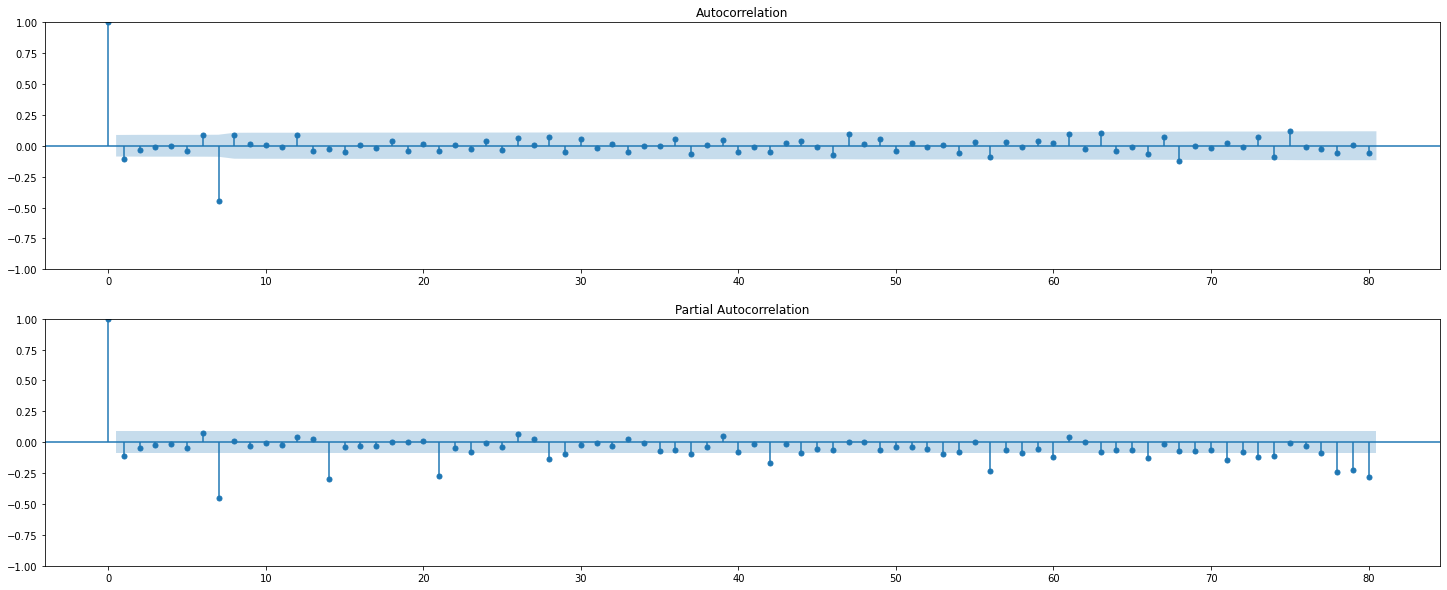

In [1163]:
plot_acf_pacf(arima_order_000, lags=80)

*How to select candidates for  and  based on ACF?*

    q: the number of the last lag t < S at which ACF was significant (S - period of seasonality)
    Q: the lag numbers t = sxm that are multiples of the seasonality period s: at which ACF was significant 
*How to select candidates for  and  based on PACF?*

    p: the number of the last lag t < S at which PACF was significant 
    P: he lag numbers t = sxm that are multiples of the seasonality period at which PACF was significant
#### Получается candidate parameters for ARIMA(p, d, q)(P, D, Q)s: 
    q = {1, 6}, Q = {1}, p = {1}, P = {1, 2, 3, ...}

### Ex. 2.5 select the best parameters of the ARIMA models iteratively.

                                 SARIMAX Results                                 
Dep. Variable:         EnergyConsumption   No. Observations:                  505
Model:             SARIMAX(0, 0, [1], 7)   Log Likelihood               -4695.140
Date:                   Sun, 27 Mar 2022   AIC                           9402.280
Time:                           17:15:09   BIC                           9427.628
Sample:                       01-09-2012   HQIC                          9412.222
                            - 05-27-2013                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Temp1        -26.2906     45.952     -0.572      0.567    -116.354      63.773
Temp2        -81.6730     44.469     -1.837      0.066    -168.830       5.484
Saturday   -6412.9363   1093

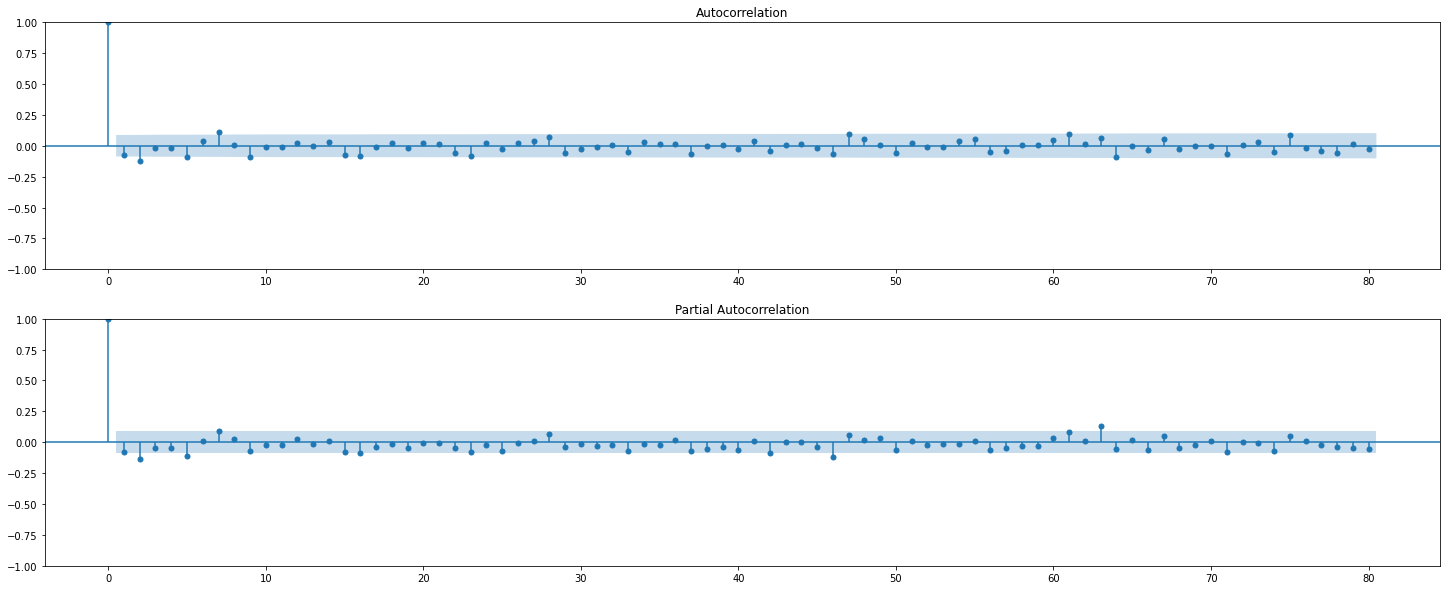

In [1164]:
# Step 1: train ARIMA(0,0,0)x(0,0,1,7)
arima_order_000_001 = sm.tsa.SARIMAX(endog=endog, exog=exogs, order=[0,0,0], seasonal_order=[0,0,1,7], freq='D').fit()
print(arima_order_000_001.summary())
plot_acf_pacf(arima_order_000_001, lags=80)

Кажется, мы почти избавились от сезонности с периодом 7.

                                        SARIMAX Results                                         
Dep. Variable:                        EnergyConsumption   No. Observations:                  505
Model:             SARIMAX(0, 0, [1, 6])x(0, 0, [1], 7)   Log Likelihood               -4692.834
Date:                                  Sun, 27 Mar 2022   AIC                           9401.668
Time:                                          17:15:11   BIC                           9435.464
Sample:                                      01-09-2012   HQIC                          9414.924
                                           - 05-27-2013                                         
Covariance Type:                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Temp1        -18.8683     46.079     -0.409      0.682    -109.181

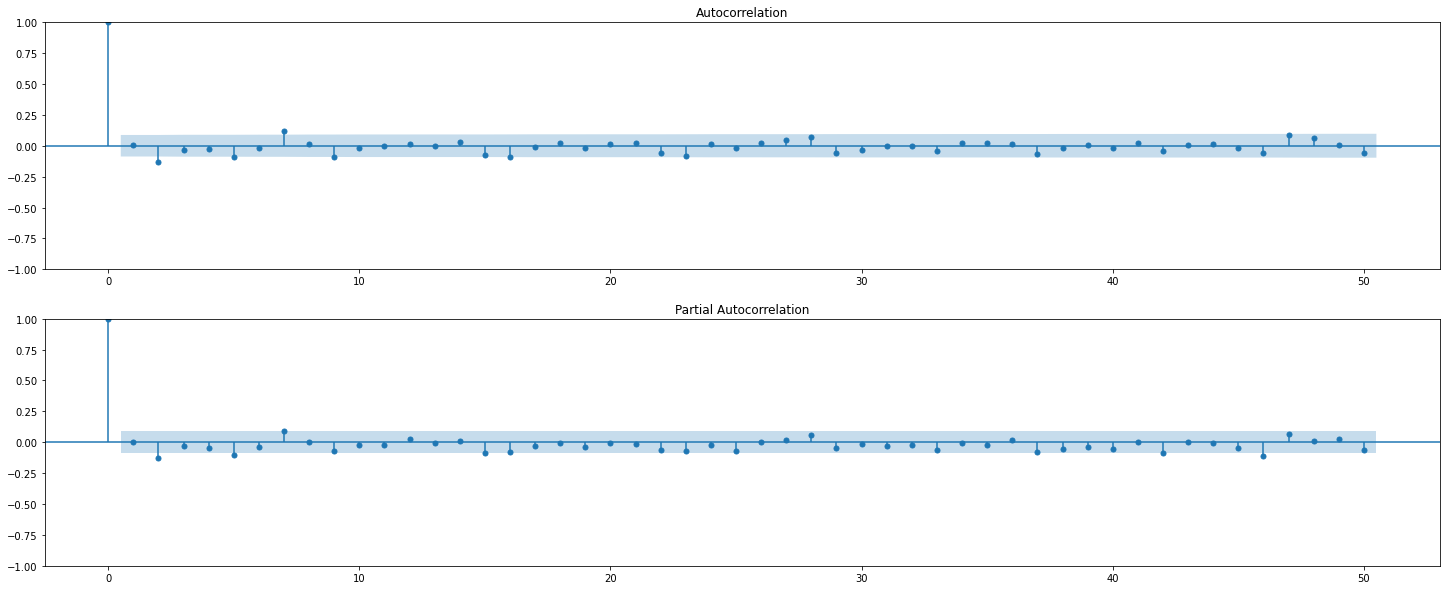

In [1165]:
arima_order_006_001 = sm.tsa.SARIMAX(endog=endog, exog=exogs, order=[0,0,(1, 6)], seasonal_order=[0,0,1,7], freq='D').fit()
print(arima_order_006_001.summary())
plot_acf_pacf(arima_order_006_001, lags=50)

                                        SARIMAX Results                                         
Dep. Variable:                        EnergyConsumption   No. Observations:                  505
Model:             SARIMAX(1, 0, [1, 6])x(0, 0, [1], 7)   Log Likelihood               -4708.882
Date:                                  Sun, 27 Mar 2022   AIC                           9435.765
Time:                                          17:15:13   BIC                           9473.786
Sample:                                      01-09-2012   HQIC                          9450.678
                                           - 05-27-2013                                         
Covariance Type:                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Temp1       -111.3891     67.107     -1.660      0.097    -242.917

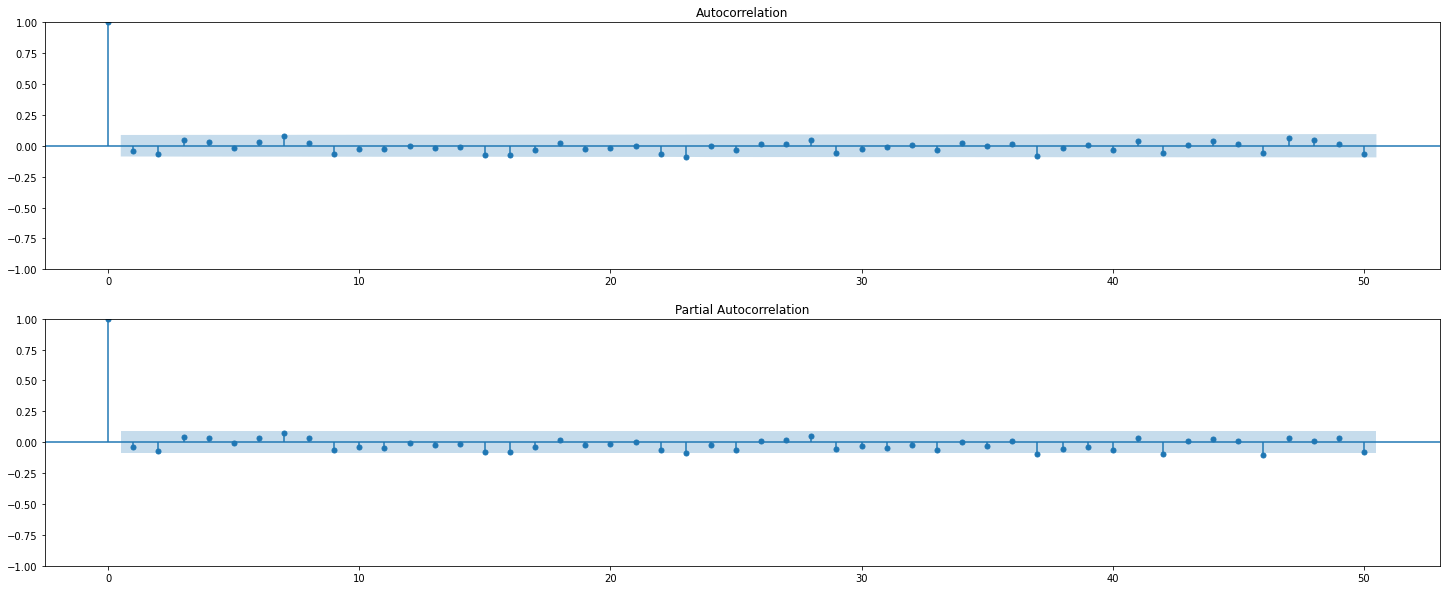

In [1166]:
arima_order_106_001 = sm.tsa.SARIMAX(endog=endog, exog=exogs, order=[1,0,(1, 6)], seasonal_order=[0,0,1,7]).fit()
print(arima_order_106_001.summary())
plot_acf_pacf(arima_order_106_001, lags=50);

                                        SARIMAX Results                                         
Dep. Variable:                        EnergyConsumption   No. Observations:                  505
Model:             SARIMAX(1, 0, [1, 6])x(1, 0, [1], 7)   Log Likelihood               -4715.083
Date:                                  Sun, 27 Mar 2022   AIC                           9450.167
Time:                                          17:15:15   BIC                           9492.412
Sample:                                      01-09-2012   HQIC                          9466.737
                                           - 05-27-2013                                         
Covariance Type:                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Temp1        -38.4504     82.869     -0.464      0.643    -200.871

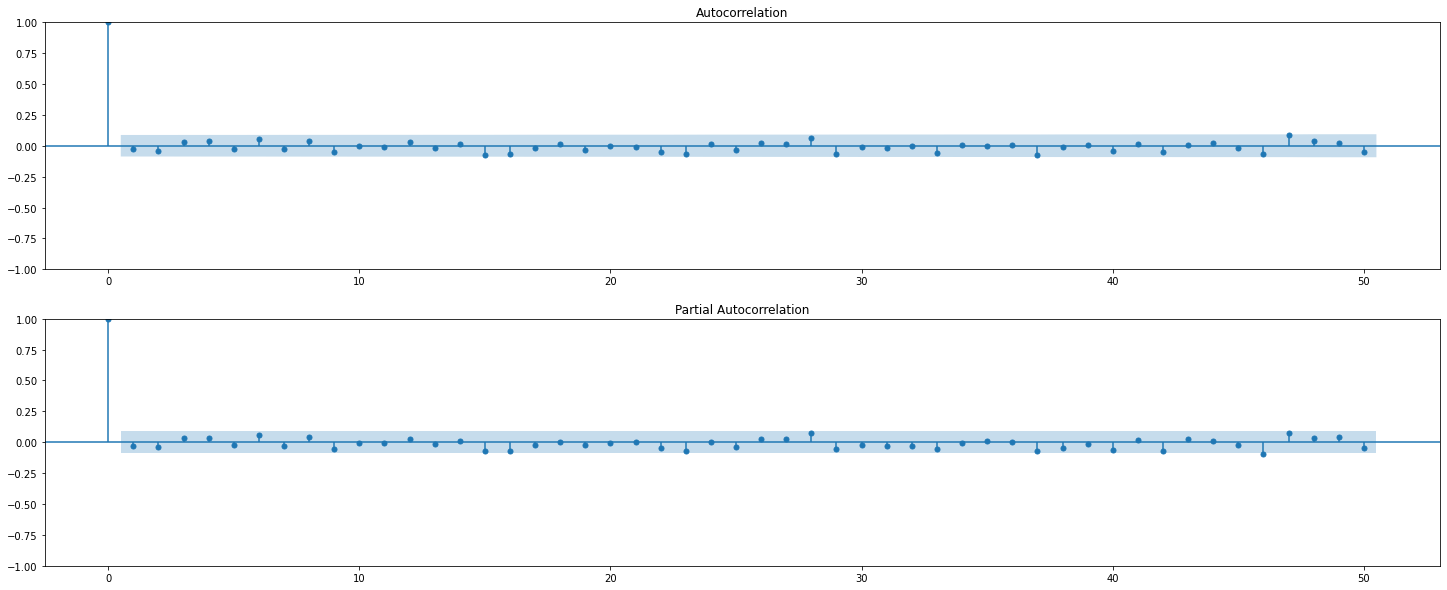

In [1167]:
arima_order_106_101 = sm.tsa.SARIMAX(endog=endog, exog=exogs, order=[1,0,(1, 6)], seasonal_order=[1,0,1,7]).fit()
print(arima_order_106_101.summary())
plot_acf_pacf(arima_order_106_101, lags=50);

#### Последняя модель ARIMA[1,0,(1, 6)]x[1,0,1,7] кажется наилучшей - корреляции на графиках ACF / PACF кажутся незначительными.

In [1168]:
arima_best = arima_order_106_101

### Ex 2.6 Check the best model residuals for unbiasedness, stationarity, non-autocorrelation, white noise hypothesis

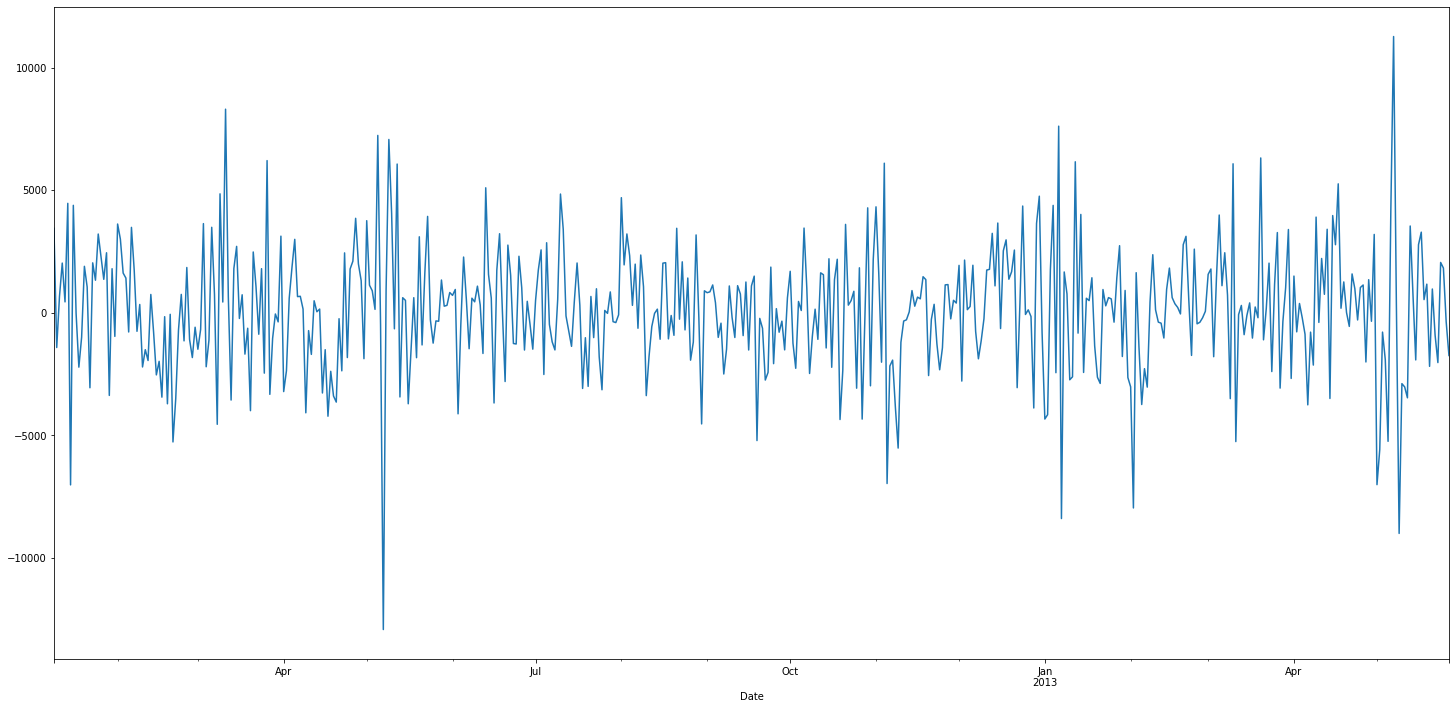

In [1170]:
arima_best.resid.plot(figsize=[25,12])
plt.plot();

#### Unbiasedness

In [1171]:
# Wilcoxon test
# H0: residuals are unbiased (https://www.statisticshowto.com/wilcoxon-signed-rank-test)
stat, p = stats.wilcoxon(arima_best.resid.values)
print('Statistic: %f\npvalue: %.2f' %(stat, p))

Statistic: 60373.000000
pvalue: 0.28


Нет оснований отвергать гипотезу о том, что остатки не смещены.

#### Autocorrelation in residuals

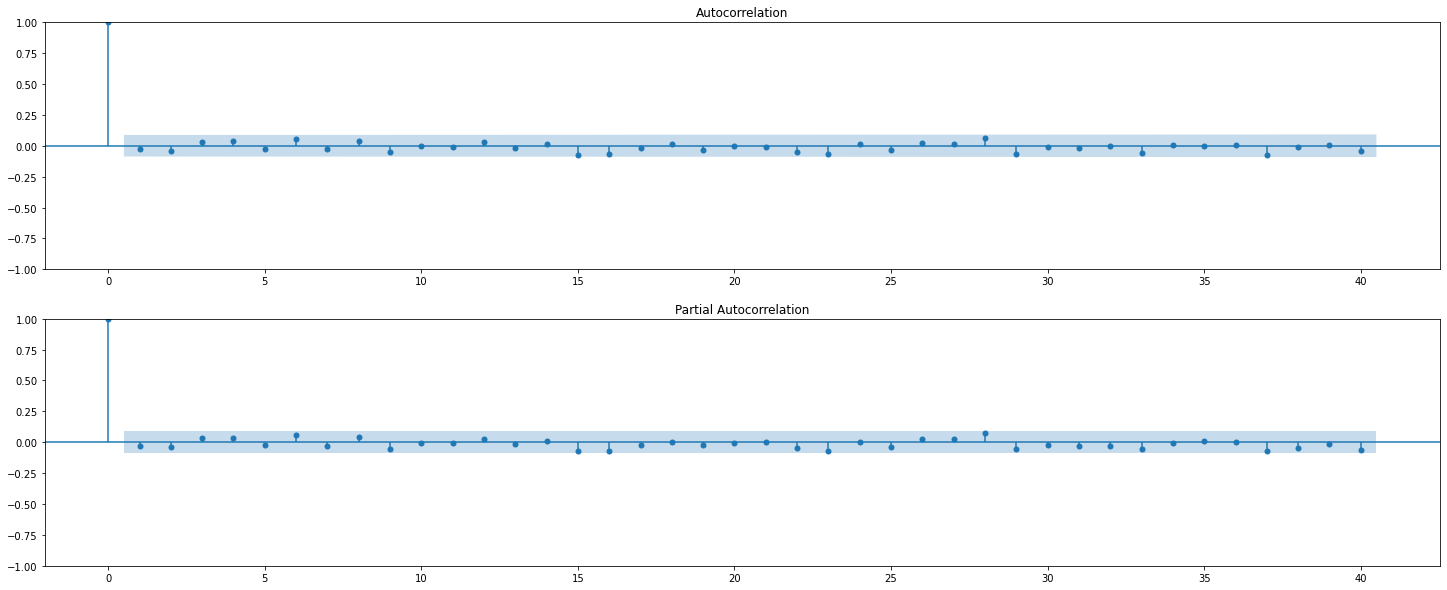

In [1172]:
# Autocorrelation analysis of residuals
fig = plt.figure(figsize=(25, 10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_best.resid.values, lags=40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_best.resid.values, lags=40, ax=ax2)


Исходя из коррелограмм ACF/PACF, нет автокорреляции в остатках

In [1173]:
# Durbin-Watson statistic
# H0: residuals are not autocorrelated (https://www.statisticshowto.com/durbin-watson-test-coefficient/)
# Must be close or equal to 2
sm.stats.durbin_watson(arima_best.resid.values)

2.04831568313986

Значение Durbin-Watson статистики близко к 2, значит, остатки не-автокоррелированы.

#### Стационарность

In [1174]:
# Augmented Dickey-Fuller unit root test: 
df_stat = stattools.adfuller(arima_best.resid.values)
print('The Augmented Dickey-Fuller test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ncritical values: %s' % 
      (df_stat[0], df_stat[1], df_stat[2], df_stat[4]))

The Augmented Dickey-Fuller test statistic -23.060811, 
pvalue: 0.00 
maximal Lag: 0 
critical values: {'1%': -3.443391504492468, '5%': -2.8672917032172953, '10%': -2.5698334393109095}


На уровне значимости 5% есть основания отвергнуть гипотезу о нестационарности остатков.

In [1175]:
# Kwiatkowski–Phillips–Schmidt–Shin
kpss_stat= stattools.kpss(arima_best.resid.values)
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.028823, 
pvalue: 0.10 
maximal Lag: 0 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


Нет оснований отвергать гипотезу о стационарности остатков. 

#### Normality test

NormaltestResult(statistic=34.06393808565978, pvalue=4.0096810564986154e-08)


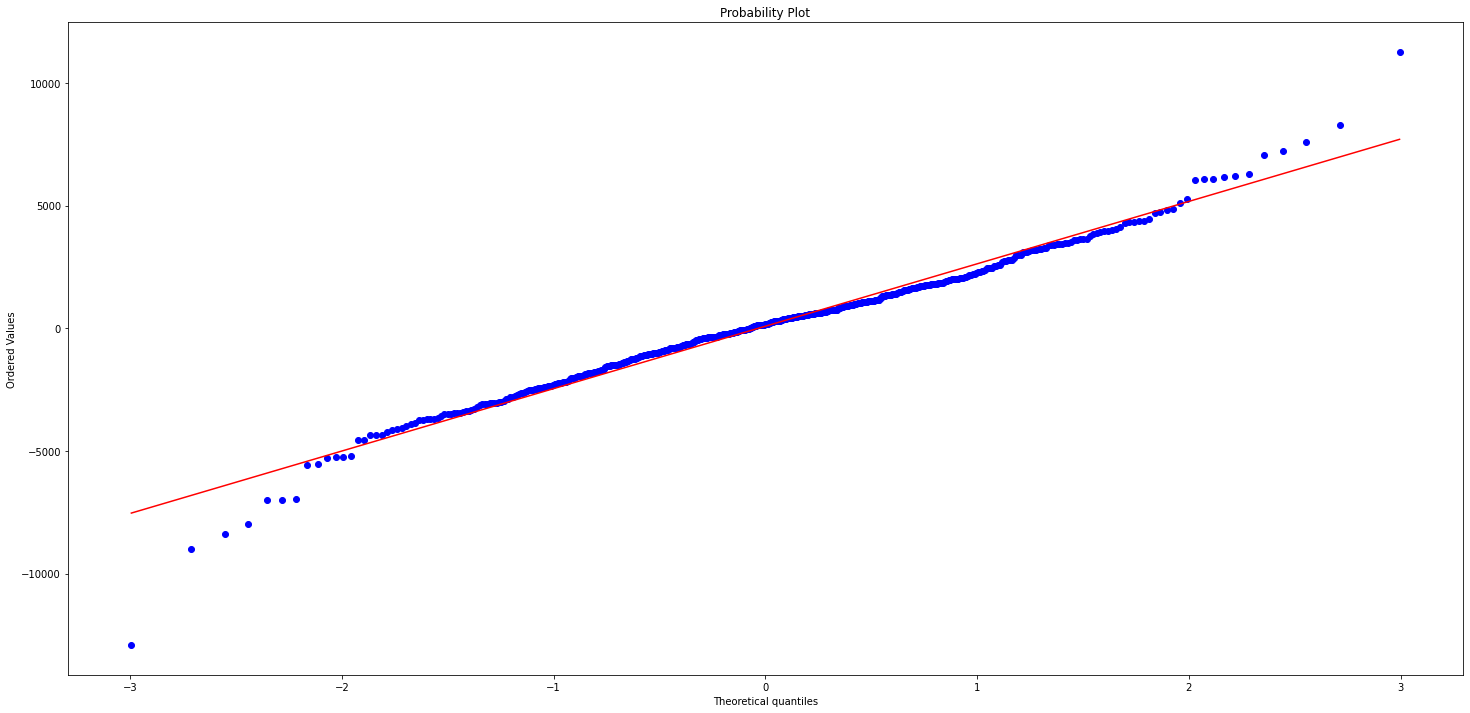

In [1176]:
# Normaliry test
# H0: residuals are normally distributed
print(stats.normaltest(arima_best.resid))

plt.figure(figsize=[25,12])
res = stats.probplot(arima_best.resid, dist="norm", plot = plt)

p-value очень мало, нет оснований не отвергать гипотезу H0. Остатки не из нормального распределения

Только один из тестов свидетельствует о неверном выборе модели.

### Ex 2.7 Run analysis of the regression coefficients

if there are some insignificant regressors that can be eliminated, please exclude them from the model.

Saturday, Sunday имеют малые p-value, оставим их. Temp1, Temp2 имеют большие p-value, от них можно избавиться.

In [1177]:
tdiff_ssdiff_ts[:-len(ts2)]

,EnergyConsumption,Temp1,Temp2,Saturday,Sunday
Date,,,,,
2012-01-09,4014.452,-9.2,-3.2,0.0,0.0
2012-01-10,10580.125,-4.6,3.3,0.0,-1.0
2012-01-11,-11012.590,-2.3,-7.2,0.0,1.0
2012-01-12,2771.163,-6.3,-8.7,0.0,0.0
2012-01-13,-264.885,0.9,7.2,0.0,0.0
...,...,...,...,...,...
2013-05-23,-3410.911,7.5,-0.2,0.0,0.0
2013-05-24,-1770.697,15.5,18.6,0.0,0.0
2013-05-25,937.456,12.5,11.7,0.0,0.0


In [1178]:
tdiff_ssdiff_ts1_1 = tdiff_ssdiff_ts[:-len(ts2)]
endog = tdiff_ssdiff_ts1_1['EnergyConsumption']
exogs = tdiff_ssdiff_ts1_1.drop(columns=['Temp1', 'Temp2', 'EnergyConsumption'])

                                      SARIMAX Results                                      
Dep. Variable:                   EnergyConsumption   No. Observations:                  505
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 7)   Log Likelihood               -4722.152
Date:                             Sun, 27 Mar 2022   AIC                           9462.304
Time:                                     17:15:26   BIC                           9500.325
Sample:                                 01-09-2012   HQIC                          9477.217
                                      - 05-27-2013                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Saturday   -6515.2597   1489.121     -4.375      0.000   -9433.883   -3596.636
Sunday     -1.227e+04    48

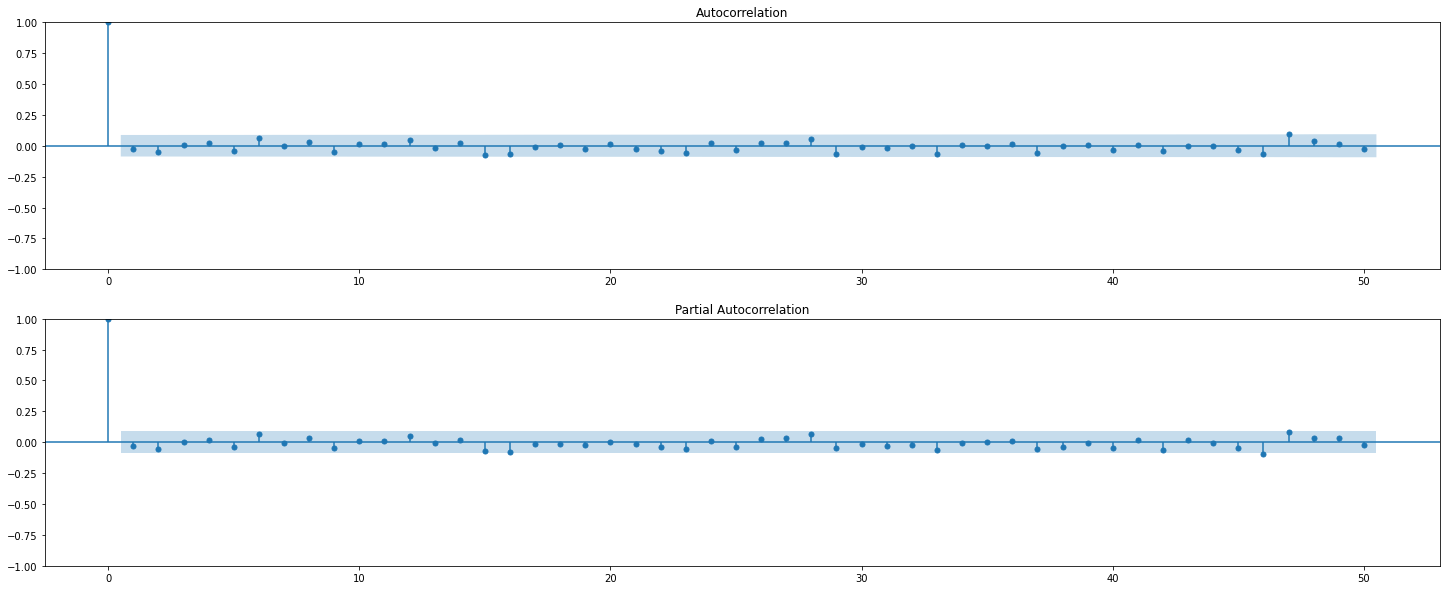

In [1179]:
arima_best = sm.tsa.SARIMAX(endog=endog, exog=exogs, order=[(1, 2),0,(1, 2)], seasonal_order=[1,0,1,7]).fit()
print(arima_best.summary())
plot_acf_pacf(arima_best, lags=50);

### Ex. 2.8 build forecast for the ts2, plot this forecast on the same plot with original ts2 data

In [1180]:
ts_sdiff_2 = sdiff_ts[-len(ts2):]
ts_sdiff_2.head(3)

,EnergyConsumption,Temp1,Temp2,Saturday,Sunday
Date,,,,,
2013-05-28,6577.503,3.0,8.2,0.0,0.0
2013-05-29,4893.931,4.5,4.8,0.0,0.0
2013-05-30,4536.660,4.0,3.8,0.0,0.0


In [1181]:
# Predict
exogs = ts_sdiff_2.drop(columns=['Temp1', 'Temp2','EnergyConsumption'])
exogs.head(3)

,Saturday,Sunday
Date,,
2013-05-28,0.0,0.0
2013-05-29,0.0,0.0
2013-05-30,0.0,0.0


In [1182]:
ts2_forecast = arima_best.forecast(steps = len(ts2), exog=exogs)

In [1183]:
ts_frc_int = (ts2_forecast + ts.shift(365)['EnergyConsumption']).iloc[-len(ts2):]
ts_frc_int[:3]

2013-05-28    127391.584179
2013-05-29    130166.117906
2013-05-30    130341.600150
dtype: float64

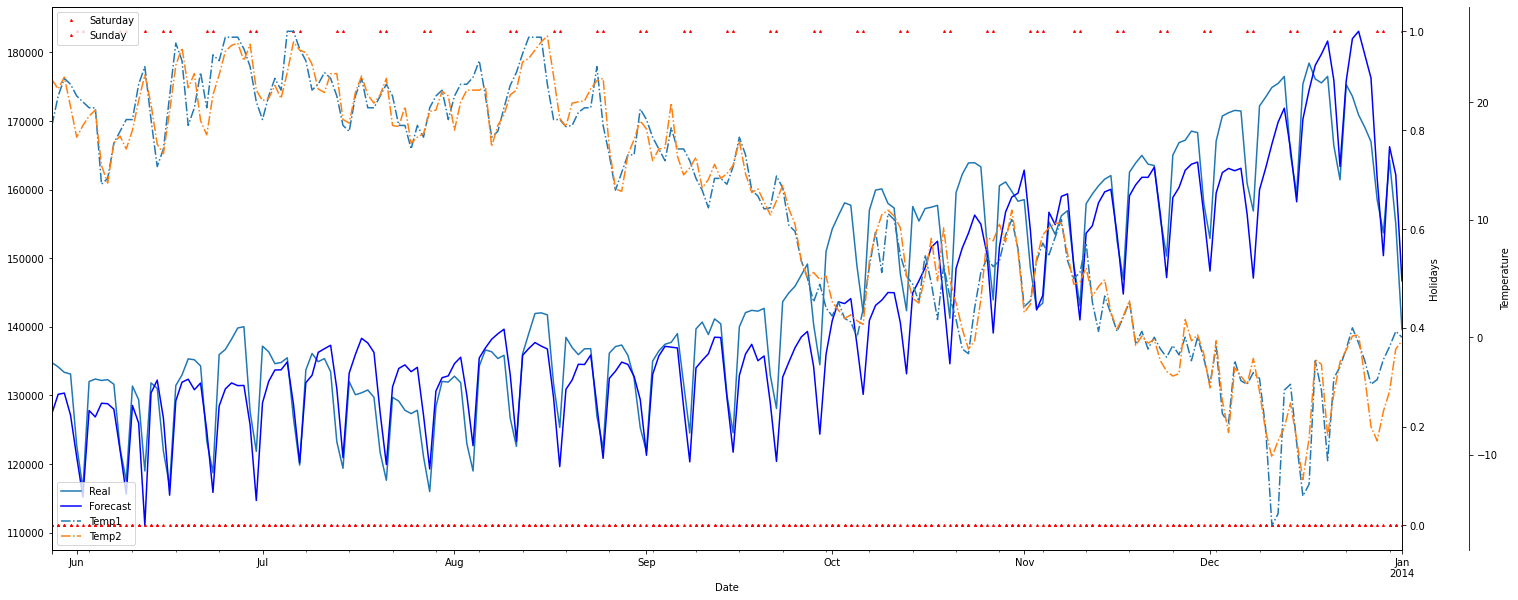

In [1184]:
# Plot the TS together with independent variables
fig, ax = plt.subplots(figsize=[30,10])
ax2, ax3 = ax.twinx(), ax.twinx()
ax2.set_ylabel('Holidays')
ax3.set_ylabel('Temperature')
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.05))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
fig.subplots_adjust(right=0.75)

ts2['EnergyConsumption'].plot(ax = ax,  label='Real')
ts_frc_int.plot(ax = ax,  style='b-', label='Forecast')
ts2[['Saturday','Sunday']].plot(ax = ax2, style='r', marker = '^', markersize = 2.0, linewidth=0.0)

for col in ts2.columns:
    if col.startswith('Temp'):
        style = '--' if col.endswith('Less') else '-.'
        ts2[col].plot(ax = ax3,  style=style)

lines = ax.get_lines() + ax3.get_lines()
ax.legend(lines, [l.get_label() for l in lines], loc='lower left', ncol=1)
ax2.legend(loc='upper left')
plt.show()

### Ex.2.9 Calculate loss MAPE of your forecast. Does the forecast look appropriate?

In [1185]:
# MAPE for the predicted TS2 
qualityMAPE(ts2['EnergyConsumption'], ts_frc_int)[0]

0.033352602475792435

In [1186]:
### MAPE for the predicted TS2 
qualityMAPE(ts2['EnergyConsumption'][:'2013-08-28'], ts_frc_int['2013-05-28':'2013-08-28'])[0]

0.02741804422999239

Хоть и ошибка мала, прогноз выглядит не особо адекватным, только первые 3-3.5 месяца более или менее правдивыми. Тем не менее прогноз не улавливает пиковые значения и резкие изменения потребления энергии, которые объясняются температурными изменениями, признаками, которые не вошли в итоговую модель.

## Ex.3 Find the best ARIMA Model automatically (30%) 

Воспользуемся результатами из предыдущего задания:

Получается candidate parameters for ARIMA(p, d, q)(P, D, Q)s:
q = {1, 6}, Q = {1}, p = {1}, P = {1, 2, 3, ...}

In [1187]:
params={'p':[0, 1], 'q':[0, 1, 6], 'P':[0, 1, 2, 3], 'Q':[1]}

In [1188]:
tdiff_ssdiff_ts1_1 = tdiff_ssdiff_ts[:-len(ts2)]
endog = tdiff_ssdiff_ts1_1['EnergyConsumption']
exogs = tdiff_ssdiff_ts1_1.drop(columns=['EnergyConsumption'])
tdiff_ssdiff_ts1_1.head(3)

,EnergyConsumption,Temp1,Temp2,Saturday,Sunday
Date,,,,,
2012-01-09,4014.452,-9.2,-3.2,0.0,0.0
2012-01-10,10580.125,-4.6,3.3,0.0,-1.0
2012-01-11,-11012.590,-2.3,-7.2,0.0,1.0


In [1189]:
df_result = pd.DataFrame()

for P in params['P']:
    for p in params['p']:
        for q in params['q']:
            for Q in params['Q']:
                arima_auto = sm.tsa.SARIMAX(endog=endog, exog=exogs, order=[p,0,q], seasonal_order=[P,0,Q,7], freq='D').fit()
                #print('p={}, q={},  P={}, Q={}'.format(p, q, P, Q))
                #print(round(arima_auto.llf), round(arima_auto.aic), round(arima_auto.bic), round(arima_auto.hqic))
                df_result[p,q,P,Q] = round(arima_auto.aic), round(arima_auto.bic), round(arima_auto.hqic)

In [1190]:
df_result

,"(0, 0, 0, 1)","(0, 1, 0, 1)","(0, 6, 0, 1)","(1, 0, 0, 1)","(1, 1, 0, 1)","(1, 6, 0, 1)","(0, 0, 1, 1)","(0, 1, 1, 1)","(0, 6, 1, 1)","(1, 0, 1, 1)",...,"(0, 6, 2, 1)","(1, 0, 2, 1)","(1, 1, 2, 1)","(1, 6, 2, 1)","(0, 0, 3, 1)","(0, 1, 3, 1)","(0, 6, 3, 1)","(1, 0, 3, 1)","(1, 1, 3, 1)","(1, 6, 3, 1)"
0,9402,9402,9437,9403,9387,9440,9397,9395,9436,9396,...,9434,9407,9435,9436,9405,9433,9439,9429,9452,9459
1,9428,9432,9488,9433,9421,9495,9426,9429,9491,9430,...,9493,9445,9478,9499,9443,9476,9502,9471,9498,9527
2,9412,9414,9457,9415,9401,9462,9408,9408,9457,9410,...,9457,9422,9452,9461,9420,9450,9464,9446,9470,9486


In [1191]:
best_arima_char = df_result.T.index[(df_result.T[0].values>=df_result.max(axis=1)[0])&(df_result.T[1].values>=df_result.max(axis=1)[1])&(df_result.T[2].values>=df_result.max(axis=1)[2])][0]
print('Best ARIMA параметры, основываясь на значениях AIC|BIC|HQIC (p, q)(P, Q):,', best_arima_char)

Best ARIMA параметры, основываясь на значениях AIC|BIC|HQIC (p, q)(P, Q):, (1, 6, 3, 1)


Пришлось перебрать все параметры, посчитать 24 раза модель, чтобы найти наилучшее решение. 

### Ex. 3.2 Run Residuals and Coefficint analysis for the best model 

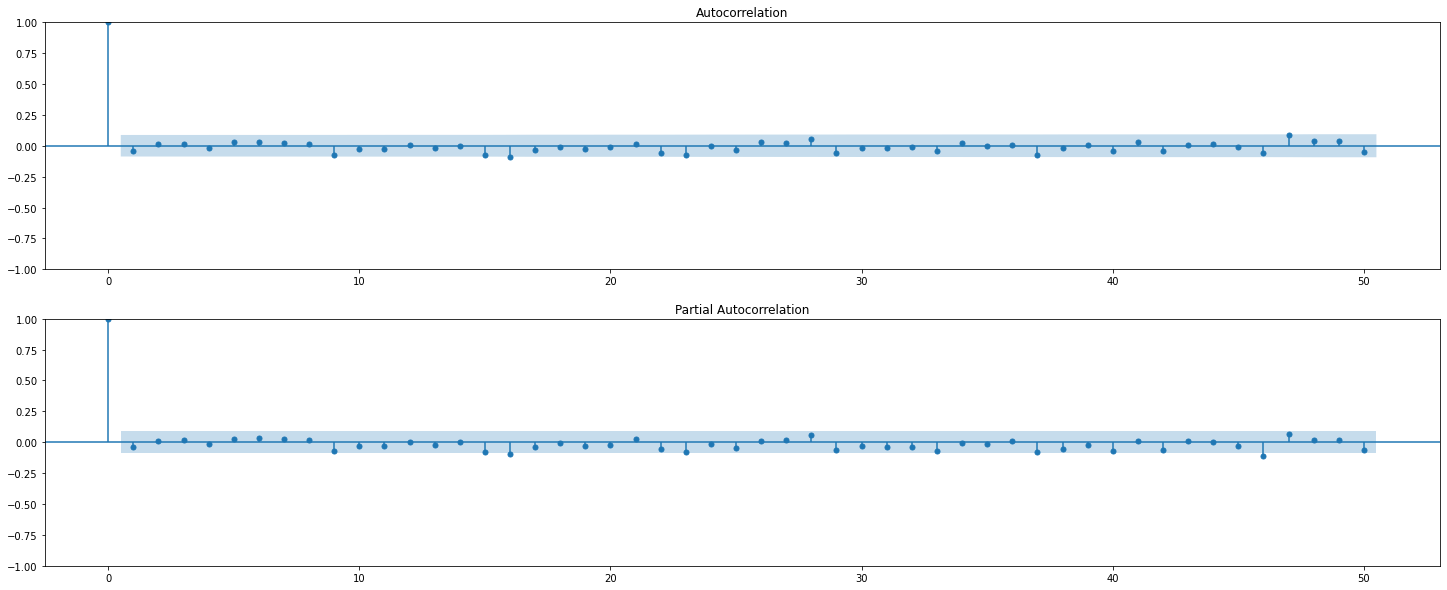

In [1192]:
arima_best = arima_auto
plot_acf_pacf(arima_best, lags=50);

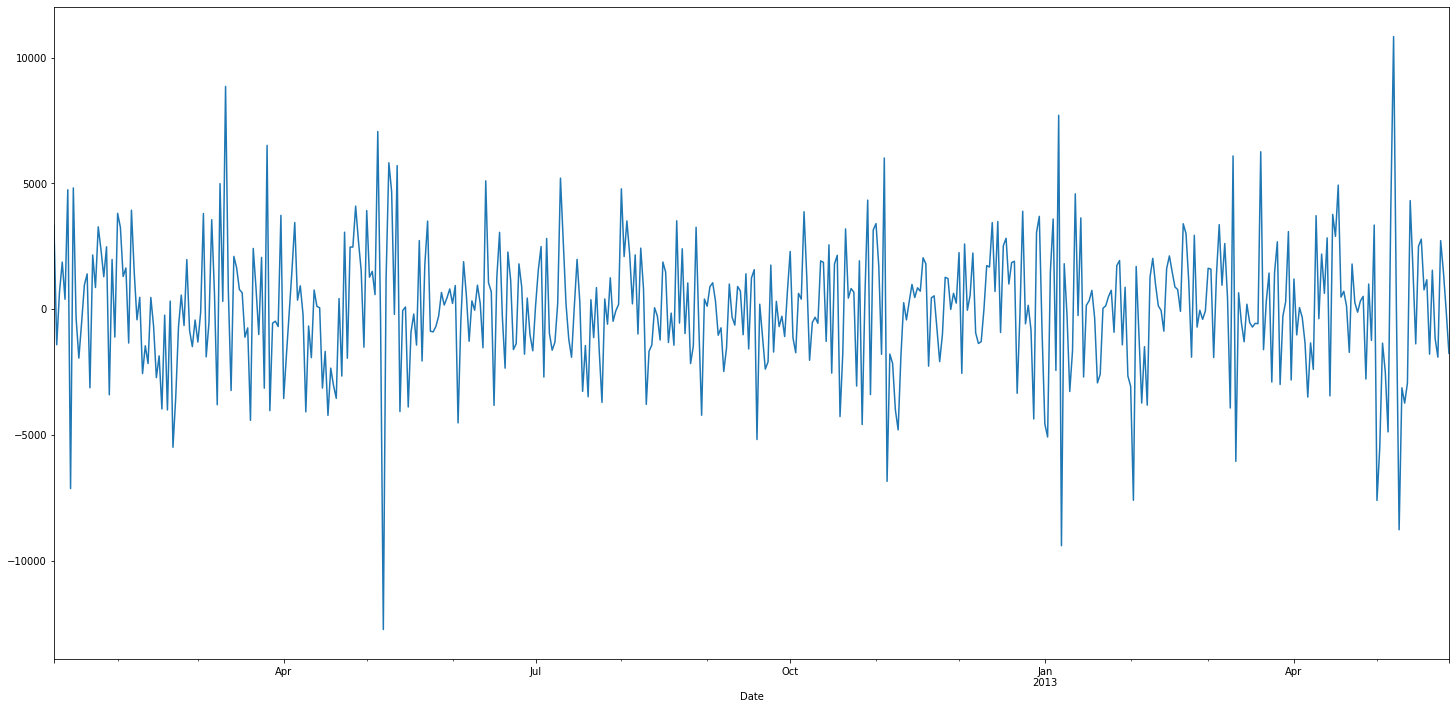

In [1193]:
arima_best.resid.plot(figsize=[25,12])
plt.plot();

In [1194]:
# Wilcoxon test
# H0: residuals are unbiased (https://www.statisticshowto.com/wilcoxon-signed-rank-test)
stat, p = stats.wilcoxon(arima_best.resid.values)
print('Statistic: %f\npvalue: %.2f' %(stat, p))

Statistic: 61506.000000
pvalue: 0.47


Нет основания отвергать нулевую гипотезу. Значение p-value выше для данной модели

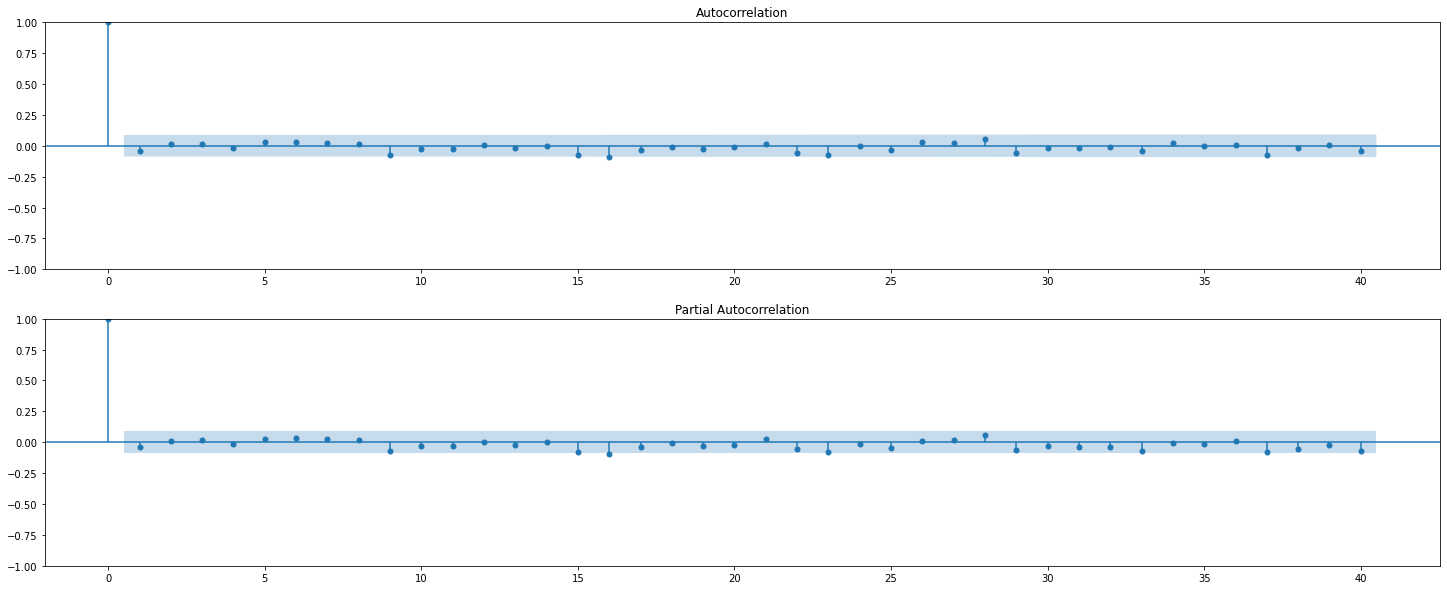

In [1195]:
# Autocorrelation analysis of residuals
fig = plt.figure(figsize=(25, 10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_best.resid.values, lags=40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_best.resid.values, lags=40, ax=ax2)

In [1196]:
# Durbin-Watson statistic
# H0: residuals are not autocorrelated (https://www.statisticshowto.com/durbin-watson-test-coefficient/)
# Must be close or equal to 2
sm.stats.durbin_watson(arima_best.resid.values)

2.0760590084231927

Статистика близка к 2, остатки не автокоррелированы.

In [1197]:
# Augmented Dickey-Fuller unit root test: 
df_stat = stattools.adfuller(arima_best.resid.values)
print('The Augmented Dickey-Fuller test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ncritical values: %s' % 
      (df_stat[0], df_stat[1], df_stat[2], df_stat[4]))

The Augmented Dickey-Fuller test statistic -23.357250, 
pvalue: 0.00 
maximal Lag: 0 
critical values: {'1%': -3.443391504492468, '5%': -2.8672917032172953, '10%': -2.5698334393109095}


Нет оснований принять 0-ю гипотезу о нестационарности.

In [1198]:
# Kwiatkowski–Phillips–Schmidt–Shin
kpss_stat= stattools.kpss(arima_best.resid.values)
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.025318, 
pvalue: 0.10 
maximal Lag: 1 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


Есть основания считать, что ряд остатков стационарен.

NormaltestResult(statistic=33.537080709745595, pvalue=5.218136725731996e-08)


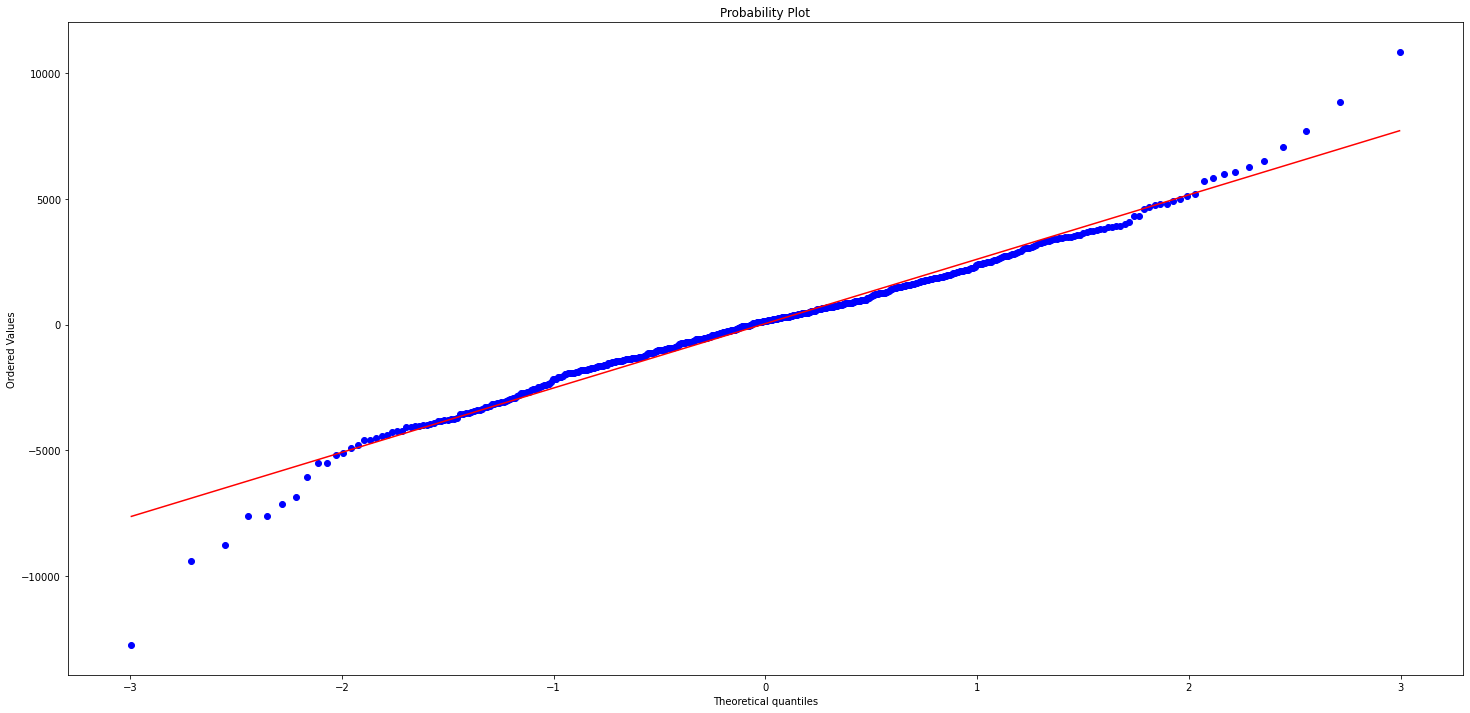

In [1199]:
# Normaliry test
# H0: residuals are normally distributed
print(stats.normaltest(arima_best.resid))

plt.figure(figsize=[25,12])
res = stats.probplot(arima_best.resid, dist="norm", plot = plt)

Остатки не из нормального распределения.

In [1200]:
print(arima_best.summary())

                                      SARIMAX Results                                      
Dep. Variable:                   EnergyConsumption   No. Observations:                  505
Model:             SARIMAX(1, 0, 6)x(3, 0, [1], 7)   Log Likelihood               -4713.652
Date:                             Sun, 27 Mar 2022   AIC                           9459.304
Time:                                     17:16:19   BIC                           9526.897
Sample:                                 01-09-2012   HQIC                          9485.816
                                      - 05-27-2013                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Temp1        -49.9286     82.876     -0.602      0.547    -212.363     112.506
Temp2        -75.8142     7

Как и в прошлый раз, исключим переменные температур.

In [1201]:
tdiff_ssdiff_ts1_1 = tdiff_ssdiff_ts[:-len(ts2)]
endog = tdiff_ssdiff_ts1_1['EnergyConsumption']
exogs = tdiff_ssdiff_ts1_1.drop(columns=['Temp1', 'Temp2', 'EnergyConsumption'])

                                      SARIMAX Results                                      
Dep. Variable:                   EnergyConsumption   No. Observations:                  505
Model:             SARIMAX(1, 0, 6)x(3, 0, [1], 7)   Log Likelihood               -4689.765
Date:                             Sun, 27 Mar 2022   AIC                           9407.529
Time:                                     17:16:23   BIC                           9466.673
Sample:                                 01-09-2012   HQIC                          9430.727
                                      - 05-27-2013                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Saturday   -6510.7404   1011.208     -6.439      0.000   -8492.672   -4528.809
Sunday      -1.23e+04    30

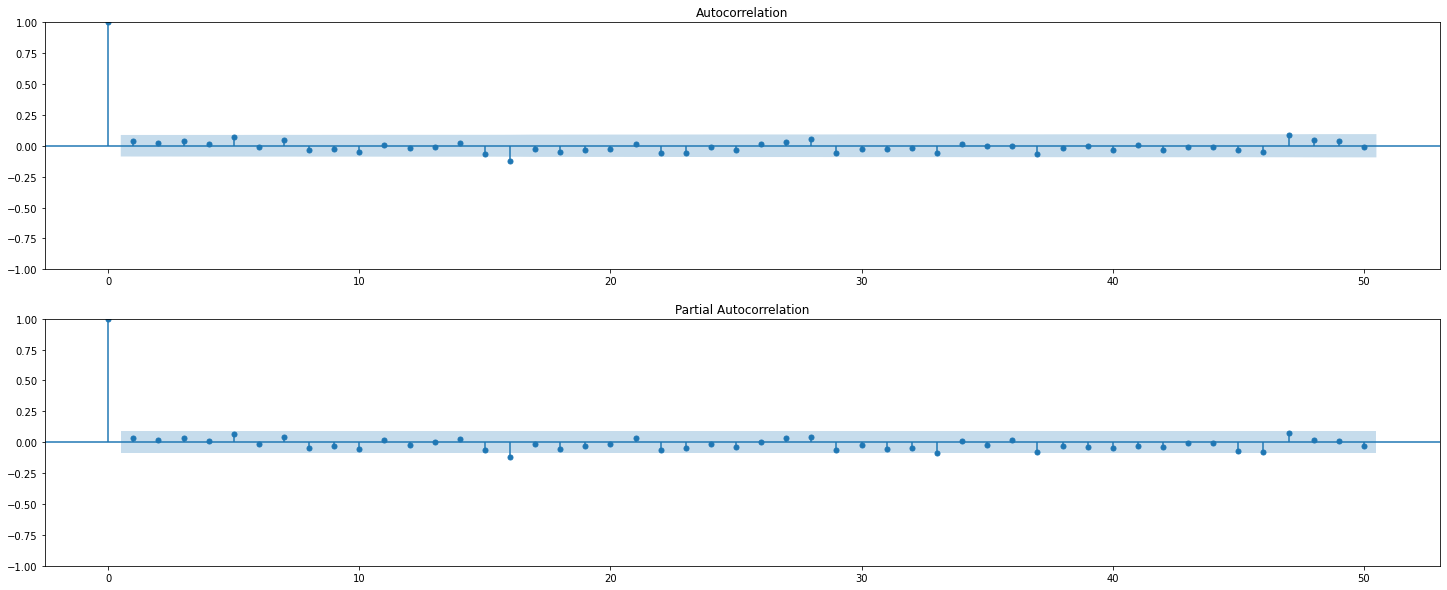

In [1202]:
arima_best = sm.tsa.SARIMAX(endog=endog, exog=exogs, order=[1,0,6], seasonal_order=[3,0,1,7], freq='D').fit()
print(arima_best.summary())
plot_acf_pacf(arima_best, lags=50);

### Ex. 3. build forecast for the ts2 

In [1203]:
ts_sdiff_2 = sdiff_ts[-len(ts2):]
ts_sdiff_2.head(3)

,EnergyConsumption,Temp1,Temp2,Saturday,Sunday
Date,,,,,
2013-05-28,6577.503,3.0,8.2,0.0,0.0
2013-05-29,4893.931,4.5,4.8,0.0,0.0
2013-05-30,4536.660,4.0,3.8,0.0,0.0


In [1204]:
# Predict
exogs = ts_sdiff_2.drop(columns=['Temp1', 'Temp2','EnergyConsumption'])
exogs.head(3)

,Saturday,Sunday
Date,,
2013-05-28,0.0,0.0
2013-05-29,0.0,0.0
2013-05-30,0.0,0.0


In [1205]:
ts2_forecast = arima_best.forecast(steps = len(ts2), exog=exogs)

In [1206]:
ts_frc_int = (ts2_forecast + ts.shift(365)['EnergyConsumption']).iloc[-len(ts2):]
ts_frc_int[:3]

2013-05-28    125765.935095
2013-05-29    130621.170103
2013-05-30    131149.239664
dtype: float64

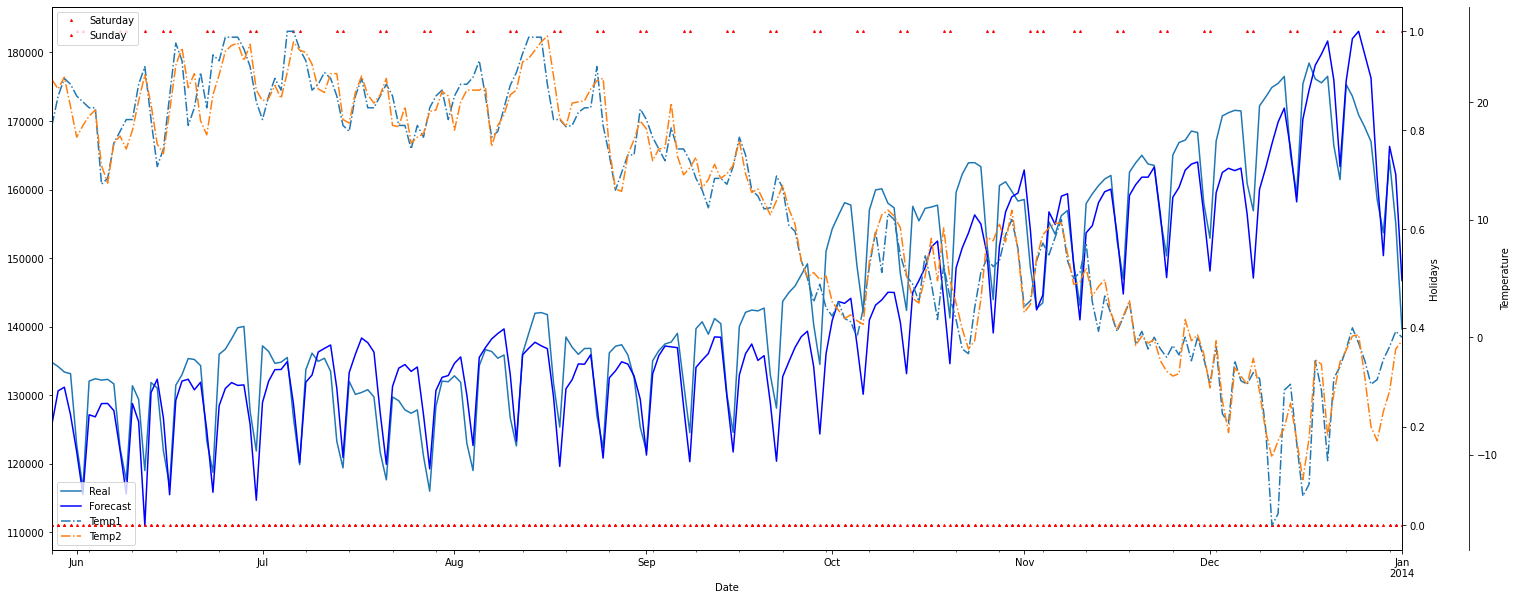

In [1207]:
# Plot the TS together with independent variables
fig, ax = plt.subplots(figsize=[30,10])
ax2, ax3 = ax.twinx(), ax.twinx()
ax2.set_ylabel('Holidays')
ax3.set_ylabel('Temperature')
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.05))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
fig.subplots_adjust(right=0.75)

ts2['EnergyConsumption'].plot(ax = ax,  label='Real')
ts_frc_int.plot(ax = ax,  style='b-', label='Forecast')
ts2[['Saturday','Sunday']].plot(ax = ax2, style='r', marker = '^', markersize = 2.0, linewidth=0.0)

for col in ts2.columns:
    if col.startswith('Temp'):
        style = '--' if col.endswith('Less') else '-.'
        ts2[col].plot(ax = ax3,  style=style)

lines = ax.get_lines() + ax3.get_lines()
ax.legend(lines, [l.get_label() for l in lines], loc='lower left', ncol=1)
ax2.legend(loc='upper left')
plt.show()

In [1208]:
# MAPE for the predicted TS2 
qualityMAPE(ts2['EnergyConsumption'], ts_frc_int)[0]

0.03336445397169569

In [1209]:
### MAPE for the predicted TS2 
qualityMAPE(ts2['EnergyConsumption'][:'2013-08-28'], ts_frc_int['2013-05-28':'2013-08-28'])[0]

0.02743006050124716

#### Ошибка прогноза модели, подобранной автоматически возросла, хоть и незначительно. Вручную подбор подходящей модели производился на основании коррелограмм, поэтому до последней модели, которая была подобрана автоматически, я просто не дошла по порядку - результаты уже на тот момент удовлетворяли моим ожиданиям. Получается, что ручной подбор модели вполне оправдал себя.